In [2]:
import numpy as np
import pandas as pd
try:
    from StringIO import StringIO
except ImportError:
    from io import StringIO
import pymc3 as pm, theano.tensor as tt
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter

In [4]:
try:
    df_all = pd.read_csv('rugby.csv')
except:
    df_all = pd.read_csv(pm.get_data('rugby.csv'), index_col=0)

In [6]:
df = df_all[['home_team', 'away_team', 'home_score', 'away_score']]

In [7]:

teams = df.home_team.unique()
teams = pd.DataFrame(teams, columns=['team'])
teams['i'] = teams.index

df = pd.merge(df, teams, left_on='home_team', right_on='team', how='left')
df = df.rename(columns = {'i': 'i_home'}).drop('team', 1)
df = pd.merge(df, teams, left_on='away_team', right_on='team', how='left')
df = df.rename(columns = {'i': 'i_away'}).drop('team', 1)

observed_home_goals = df.home_score.values
observed_away_goals = df.away_score.values

home_team = df.i_home.values
away_team = df.i_away.values

num_teams = len(df.i_home.drop_duplicates())
num_games = len(home_team)

In [112]:
with pm.Model() as model:
    # global model parameters
    home = pm.Flat('home')
    # home = pm.DiscreteUniform('home',lower=0,upper=10)
    # home = pm.Exponential('home',1)
    # home = pm.Gamma('home',1.5,10e-4)
    sd_att = pm.HalfStudentT('sd_att', nu=3, sigma=2.5)
    sd_def = pm.HalfStudentT('sd_def', nu=3, sigma=2.5)
    intercept = pm.Flat('intercept')
    # intercept = pm.DiscreteUniform('intercept',lower=0,upper=10)
    # intercept = pm.Exponential('intercept',1)
    # intercept = pm.Gamma('intercept',1.5,10e-4)

    # team-specific model parameters
    atts_star = pm.Normal("atts_star", mu=0, sigma=sd_att, shape=num_teams)
    defs_star = pm.Normal("defs_star", mu=0, sigma=sd_def, shape=num_teams)

    atts = pm.Deterministic('atts', atts_star - tt.mean(atts_star))
    defs = pm.Deterministic('defs', defs_star - tt.mean(defs_star))
    home_theta = tt.exp(intercept + home + atts[home_team] + defs[away_team])
    away_theta = tt.exp(intercept + atts[away_team] + defs[home_team])

    # likelihood of observed data
    home_points = pm.Poisson('home_points', mu=home_theta, observed=observed_home_goals)
    away_points = pm.Poisson('away_points', mu=away_theta, observed=observed_away_goals)

In [113]:
with model:
    trace = pm.sample(1000)
    posterior = pm.sample_posterior_predictive(trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [defs_star, atts_star, intercept, sd_def, sd_att, home]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 18 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


In [89]:
trace['atts_star']

array([[ 0.21715257, -0.0345049 ,  0.08273704, -0.19223948, -0.35634927,
         0.21975347],
       [ 0.08327779, -0.2215575 , -0.06969357, -0.34914398, -0.50446895,
         0.03574823],
       [ 0.7925368 ,  0.4427434 ,  0.66011396,  0.44983876,  0.23558491,
         0.82550905],
       ...,
       [ 0.14404274, -0.09400204,  0.03760672, -0.20801327, -0.41848819,
         0.25754179],
       [ 0.28463743,  0.19496988,  0.27553463,  0.07723162, -0.16752846,
         0.3364476 ],
       [ 0.31032331, -0.12068497,  0.21086197, -0.02137993, -0.22186531,
         0.35531279]])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f850eb315d0>,
      dtype=object)

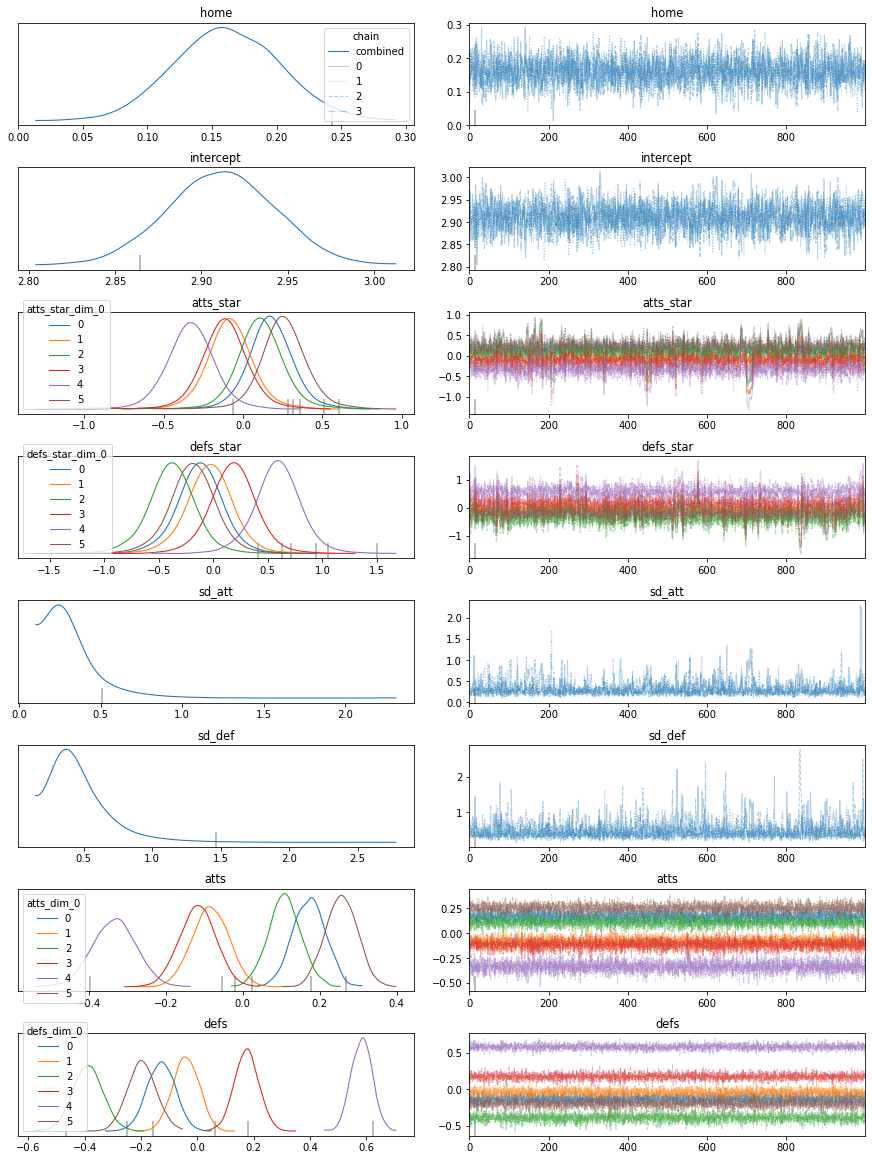

In [114]:
pm.traceplot(trace, legend=True, combined=True)

In [61]:
import arviz as az
import panel as pn

with model:
    pm_data = az.from_pymc3(
            trace=trace,
            posterior_predictive=posterior,
    )

In [66]:
def convert_models(models=[]):
    model_data = []
    for m in models:
        with m:
            data = az.from_pymc3(
                        trace=trace,
                        # prior=prior,
                        posterior_predictive=posterior,
                    )
            model_data.append(data)
    return model_data

In [117]:
        from bokeh.palettes import Dark2_5 as palette
        import itertools

        colors = itertools.cycle(palette) 
        curdoc().theme = 'dark_minimal'
        kw = dict(outline_line_color=colors)
        plot = az.plot_trace(
            trace, 
            var_names='atts_star', 
            backend='bokeh',
            legend=True,
            compact=True,
            combined=True,
            )

In [67]:
m = [model]
data_m = convert_models(m)
models = {
  "prior_1": data_m[0],
}

In [100]:
import bokeh as Bokeh
import bokeh.plotting as bkp
from bokeh.models import Div
from bokeh.layouts import column, row
from bokeh.io import curdoc

def prior_density_plot(variable,data=models, plottype='Seperate Plots'):
    """
    Method for producing the prior kde plot using arviz plot_density. This is done 2 ways: either will produce all     the plots onto one graph or will produe them seperately

    The parameters are the data, plottype, either "Seperate Plots" or "Same Plots" 

    Also takes the variable to view which will be chosen by the dropdown in the program. Probably shouldnt be          hardcoded with a default as this will change with each model.  *** Will change later ***
    """
    if plottype == 'Seperate Plots':
        plots = []
        for key, value in data.items():
            kwg = dict(title=key)
            curdoc().theme = 'dark_minimal'
            plot = az.plot_density(
                value,
                group='prior', 
                var_names=variable,
                outline=False, 
                backend='bokeh',
                shade=.5, 
                show=False,
                backend_kwargs=kwg
                )
            """ ** Can't get the title to change with kwargs so workaround with html div ** """
            plots.append(column(Div(text='<h2>'+key+'</h2>'),row(plot[0].tolist(), sizing_mode='scale_both')))
        col = column(plots)
    else:
        curdoc().theme = 'dark_minimal'
        plot = az.plot_density(
            list(data.values()), 
            group='prior', 
            var_names=variable,
            outline=False,  
            backend='bokeh',
            shade=.5, 
            show=False, 
            colors='cycle'
            )
        col = column(plot[0].tolist())
    return col


def posterior_density_plot(variable, data=models, plottype='Seperate Plots'):
    """
    Basically the sama as the prior density plot but uses the posterior instead. Could have resused the same           method with an extra param but the panel.interact method tries to create features for parameter selection          which i dont want in this case

    *** will try to find a workaround for this feature to reduce unnescesary code copying***
    """
    if plottype == 'Seperate Plots':
        plots = []
        for key,value in data.items():
            curdoc().theme = 'dark_minimal'
            kwg = dict(title=key)
            plot = az.plot_density(
                value, 
                group='posterior', 
                var_names=variable, 
                backend='bokeh',
                outline=False,
                shade=.5, 
                show=False,
                backend_kwargs=kwg
                )
            plots.append(column(Div(text='<h2>'+key+'</h2>'),row(plot[0].tolist(), sizing_mode='scale_both')))
        col = column(plots)
    else:
        curdoc().theme = 'dark_minimal'
        plot = az.plot_density(
            list(data.values()), 
            group='posterior', 
            var_names=variable, 
            backend='bokeh',
            shade=.5, 
            show=False, 
            colors='cycle',
            outline=False, 
            )
        col = column(plot[0].tolist())
    return col


def prior_predictive_density_plot(variable, data=models):
    plots = []
    for key, value in data.items():
        kwg = dict(title=key)
        curdoc().theme = 'dark_minimal'
        plot = az.plot_ppc(
            value, 
            group='prior', 
            var_names=variable, 
            backend='bokeh',
            alpha=.5, 
            show=False,
            backend_kwargs=kwg
            )
        plots.append(column(Div(text='<h2>'+key+'</h2>'),row(plot[0].tolist(), sizing_mode='scale_both')))
    col = column(plots)
    return col

def posterior_predictive_density_plot(variable, data=models):
    plots = []
    for key, value in data.items():
        kwg = dict(title=key)
        curdoc().theme = 'dark_minimal'
        plot = az.plot_ppc(
            value, 
            group='posterior', 
            var_names=variable, 
            backend='bokeh',
            alpha=.5, 
            show=False,
            backend_kwargs=kwg
            )
        plots.append(row(plot[0].tolist(), sizing_mode='scale_both'))
    col = column(plots)
    return col


def sample_trace_plot(variable, data=models):
    plots = []
    for key, value in data.items():
        kwg = dict(height=200,title=key)
        curdoc().theme = 'dark_minimal'
        plot = az.plot_trace(
            value, 
            var_names=variable, 
            backend='bokeh', 
            show=False,
            backend_kwargs=kwg,
            compact=True,
            combined=True,
            )
        plots.append(column(Div(text='<h2>'+key+'</h2>'),row(plot[0].tolist(), sizing_mode='scale_both')))
    col = column(plots)
    return col

In [18]:
from bokeh.plotting import show



pn.extension()

radio_group = pn.widgets.RadioButtonGroup(
    name='Radio Button Group', options=['Same Plot', 'Seperate Plots'], button_type='success')

def prior_view_tab():
    kw = dict(variable=sorted(list(pm_data.prior.data_vars)), plottype=radio_group)
    i = pn.interact(prior_density_plot, **kw)
    text = "Hey"
    p = pn.Row(text,pn.Row(pn.Column(i[0][0],i[0][1]),i[1]))
    return p



def posterior_view_tab():
    kw = dict(variable=sorted(list(pm_data.posterior.data_vars)),plottype=radio_group)
    i = pn.interact(posterior_density_plot, **kw)
    text = "Hey"
    p = pn.Row(text,pn.Row(pn.Column(i[0][0],i[0][1]),i[1]))
    return p

def prior_predictive_view_tab():
    kw = dict(variable=sorted(list(pm_data.prior_predictive.data_vars)))
    i = pn.interact(prior_predictive_density_plot, **kw)
    text = "Hey"
    p = pn.Row(text,pn.Row(i[0],i[1]))
    return p

def posterior_predictive_view_tab():
    kw = dict(variable=sorted(list(pm_data.posterior_predictive.data_vars)))
    i = pn.interact(posterior_predictive_density_plot, **kw)
    text = "Hey"
    p = pn.Row(text,pn.Row(i[0],i[1]))
    return p

def sample_trace_view_tab():
    kw = dict(variable=sorted(list(pm_data.posterior.data_vars)))
    i = pn.interact(sample_trace_plot, **kw)
    text = "Hey"
    p = pn.Row(text,pn.Row(i[0],i[1]))
    return p

In [101]:
tabs = pn.Tabs(('Posterior', posterior_view_tab),('Posterior Predictive',posterior_predictive_view_tab),('Sample Trace', sample_trace_view_tab))
pn.serve(tabs)

Launching server at http://localhost:63031
